In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from glob import glob
import pickle
from pprint import pprint
import random
import traceback
from tqdm import tqdm

import numpy as np
import pandas as pd
from PIL import Image

import cv2
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
plt.rcParams["figure.figsize"] = (12, 9)
sns.set_style("darkgrid")

In [4]:
IMG_WIDTH = 600
IMG_HEIGHT = 300

## Loading the train and test data

In [5]:
train = glob("../input/arya-hw-lines/train/train/*.tif")
test = glob("../input/arya-hw-lines/test/test/*.tif")

In [6]:
len(train), len(test)

(11000, 994)

In [7]:
image = cv2.imread(train[0], 0)
label = open(train[0].replace(".tif", ".gt.txt")).read()

THEY HELP ARE PERSONS WHO ARE


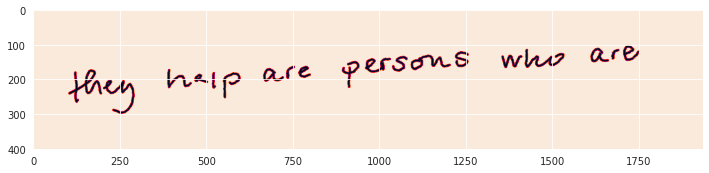

In [8]:
print(label)
_ = plt.imshow(image)

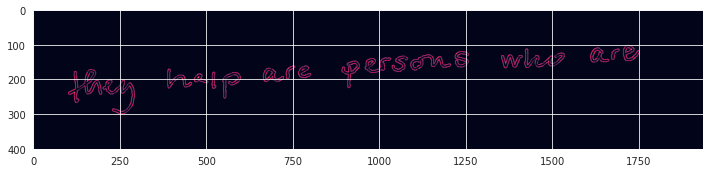

In [9]:
image_invert = np.abs(image-255)
_ = plt.imshow(image_invert)

In [10]:
vert_sum = np.sum(image_invert, axis=0)
hori_sum = np.sum(image_invert, axis=1)
len(vert_sum), len(hori_sum)

(1935, 401)

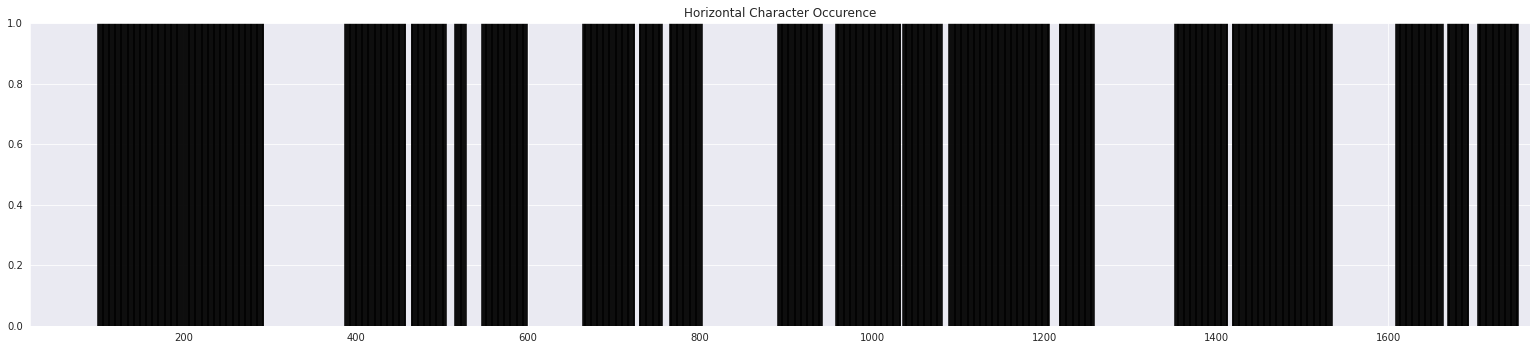

In [11]:
px = 1/plt.rcParams['figure.dpi']
plt.subplots(figsize=(1935*px, 401*px))
xposition = list(range(0, image_invert.shape[1]))
for xc in xposition:
    if vert_sum[xc] > 0:
        plt.axvline(x=xc, color='k')
_ = plt.title("Horizontal Character Occurence")

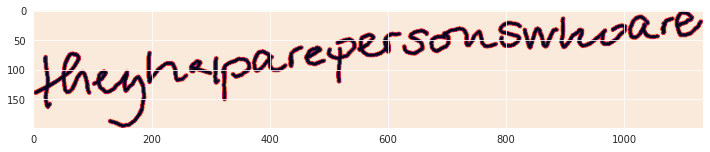

In [12]:
# consider only those horizontal & vertical sections where atleast one pixel value>0
image_reduced  = image[hori_sum>0,:][:,vert_sum>0]
_ = plt.imshow(image_reduced)

In [13]:
# stores the index at which 0 starts as keys & the consecutive number of 0 pixels as value
gaps = {}
sanchk = True
tmp_ind = 0
for ind, i in enumerate(vert_sum):
    if i==0:
        if sanchk:
            tmp_ind = ind
            gaps[tmp_ind] = 0
        gaps[tmp_ind]+=1
        sanchk = False
    else:
        sanchk = True

In [14]:
pprint(gaps)
len(vert_sum[vert_sum==0]), sum(gaps.values())

{0: 101,
 200: 1,
 294: 94,
 459: 6,
 506: 10,
 529: 18,
 600: 64,
 725: 5,
 757: 8,
 803: 88,
 943: 15,
 1034: 2,
 1082: 8,
 1207: 11,
 1259: 93,
 1414: 5,
 1535: 74,
 1664: 5,
 1694: 10,
 1752: 183}


(801, 801)

In [15]:
# cutting off whitespaces at the start & end (along x-axis)
start_ind = 0
end_ind = vert_sum.shape[0]-1
if 0 in gaps:
    start_ind = gaps[0]
    del gaps[0]
gaps_last = max(gaps.keys())
if gaps_last+gaps[gaps_last]-1 == end_ind:
    end_ind = gaps_last
    del gaps[gaps_last]
image = image[hori_sum>0,:][:,start_ind:end_ind]

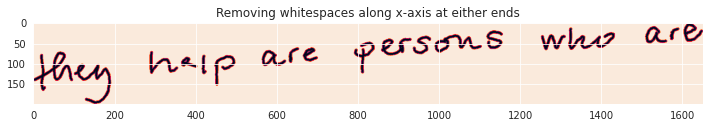

In [16]:
plt.imshow(image)
_ = plt.title("Removing whitespaces along x-axis at either ends")

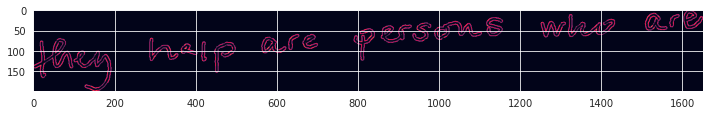

In [17]:
image_invert = np.abs(image-255)
_ = plt.imshow(image_invert)

In [18]:
# re-calculating gap after removing whitespaces
vert_sum = np.sum(image_invert,axis=0)
gaps = {}
sanchk = True
tmp_ind = 0
for ind, i in enumerate(vert_sum):
    if i==0:
        if sanchk:
            tmp_ind = ind
            gaps[tmp_ind] = 0
        gaps[tmp_ind]+=1
        sanchk = False
    else:
        sanchk = True

In [19]:
gaps

{99: 1,
 193: 94,
 358: 6,
 405: 10,
 428: 18,
 499: 64,
 624: 5,
 656: 8,
 702: 88,
 842: 15,
 933: 2,
 981: 8,
 1106: 11,
 1158: 93,
 1313: 5,
 1434: 74,
 1563: 5,
 1593: 10}

*Based on the hypothesis that distance between 2 words is more than intra-word space as well as space between two characters*

In [20]:
text_pieces = label.split(" ")
label_length = len(text_pieces)
# minimum gap between two words
min_gap = sorted(gaps.values())[-label_length]

In [21]:
print(sorted(gaps.values()))
print(f"Minimum gap between 2 words: {min_gap}")

[1, 2, 5, 5, 5, 6, 8, 8, 10, 10, 11, 15, 18, 64, 74, 88, 93, 94]
Minimum gap between 2 words: 18


In [22]:
# split image only if gap > minimum gap & store the starting pixel index for the word
splits = np.arange(vert_sum.shape[0])[[k for k in gaps.keys() if gaps[k]>min_gap]]
print(f"Starting index for each word (x-axis): {splits}")

Starting index for each word (x-axis): [ 193  499  702 1158 1434]


In [23]:
if splits.shape[0]>0:
    image_splits = np.split(image,indices_or_sections=splits,axis=1)
else:
    image_splits = [image]
    splits = [0]

**Setting maximum `image_width` to 600 pixels, since the plan is to anyway train the model on words lesser than 8 characters**

In [24]:
image_pieces = []
for ind, tmp in enumerate(image_splits):
    start_index = gaps[splits[ind-1]] if ind>0 else 0
    if tmp[:, start_index:].shape[1]==0:
        continue
    image_pieces.append(np.pad(tmp[:,start_index:], 
                               ((0, IMG_HEIGHT-tmp[:,start_index:].shape[0]), (0, IMG_WIDTH-tmp[:,start_index:].shape[1])),
                               'constant', 
                               constant_values=255))

In [25]:
text_pieces

['THEY', 'HELP', 'ARE', 'PERSONS', 'WHO', 'ARE']

In [26]:
all_labels = []

In [27]:
count = 0
if len(text_pieces) == len(image_pieces):
    for image in image_pieces:
        Image.fromarray(image).save(f"{count}.png")
        count+=1
    all_labels.extend(text_pieces)

In [28]:
df = pd.DataFrame.from_dict({"Path": list(range(count)), "Labels": all_labels})
df["Path"] = df["Path"].apply(lambda x: str(x)+".png")

In [29]:
def plot_grid(files, labels=None, h=3, w=3, title=""):
    if not labels:
        labels = [""]*len(files)
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    for idx, (path, label) in enumerate(random.choices(list(zip(files, labels)), k=h*w)):
        image = cv2.imread(path, 0)
        
        ax[idx // h, idx % w].imshow(image)
        ax[idx // h, idx % w].axis("off")
        ax[idx // h, idx % w].set_title(f"{path.split('/')[-1]} - {label}")
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

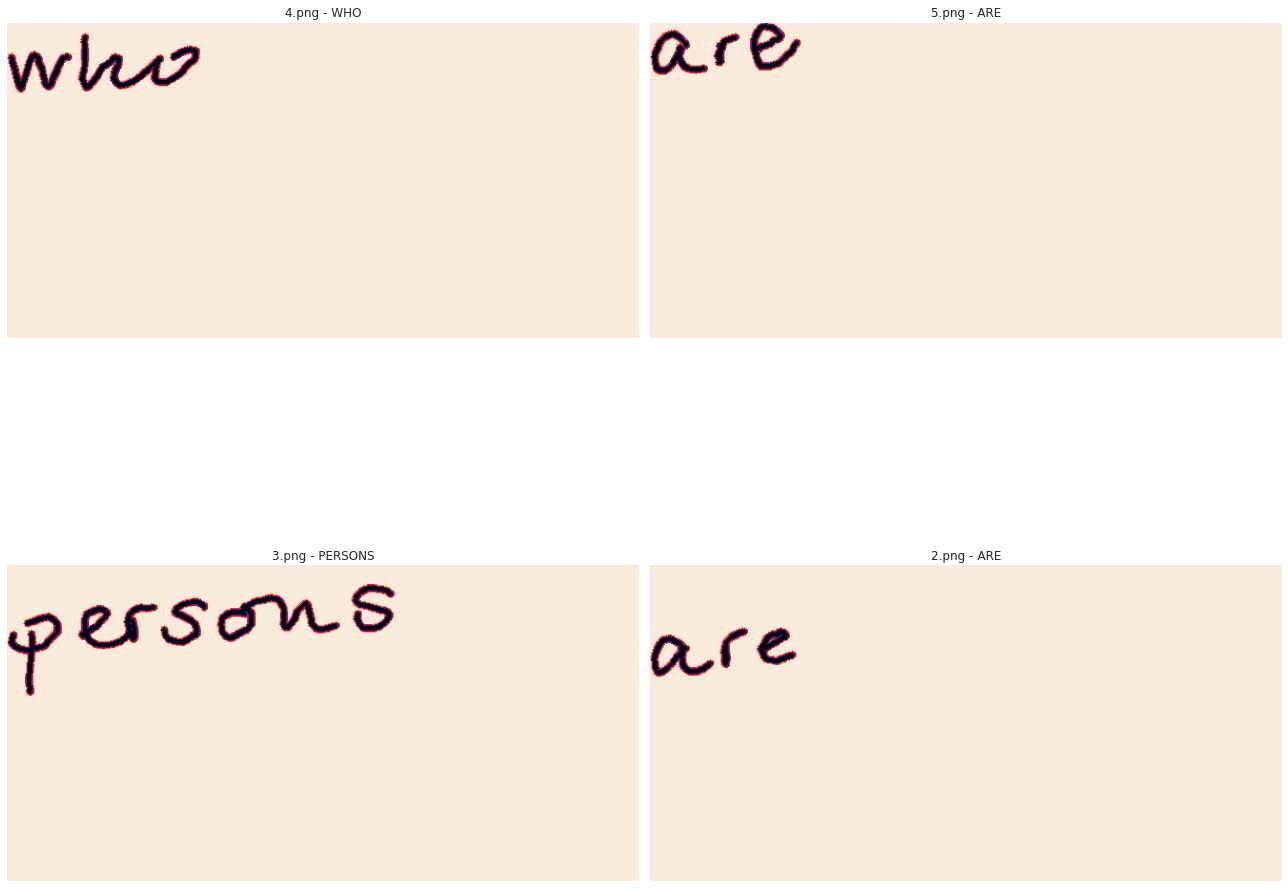

In [30]:
plot_grid(df["Path"].tolist(), df["Labels"].tolist(), h=2, w=2)

## Remove Error Cases

Refer here - https://www.kaggle.com/aditya08/initial-exploration?scriptVersionId=58103586&cellId=33

In [31]:
issue = issue = ["g04-036-07.tif", "d09-651z-05.tif", "f06-396z-09.tif", 
                 "f04-310z-05.tif", "f07-425z-08.tif", "b06-032-09.tif", 
                 "l06-637z-06.tif", "d03-229z-06.tif", "n10-277z-06.tif", 
                 "n01-015z-04.tif", "n01-062z-07.tif", "d05-380z-06.tif"]
issue = [f"../input/arya-hw-lines/train/train/{x}" for x in issue]

In [32]:
train = list(set(train) - set(issue))

In [33]:
len(train)

10988

## All in One

In [34]:
!mkdir images

In [35]:
count, error_count, all_labels = 0, 0, []
image_paths, subimage_splits, image_counts = [], [], []
h_shape, w_shape, aspect_ratio = [], [], []
for fnum in tqdm(range(len(train))):
    prev_count = count
    try:
        image = cv2.imread(train[fnum], 0)
        label = open(train[fnum].replace(".tif", ".gt.txt")).read()
        image_invert = np.abs(image-255)
        vert_sum = np.sum(image_invert,axis=0)
        hori_sum = np.sum(image_invert,axis=1)
        image_reduced  = image[hori_sum>0,:][:,vert_sum>0]
        
        gaps = {}
        sanchk = True
        tmp_ind = 0
        for ind, i in enumerate(vert_sum):
            if i==0:
                if sanchk:
                    tmp_ind = ind
                    gaps[tmp_ind] = 0
                gaps[tmp_ind]+=1
                sanchk = False
            else:
                sanchk = True
        start_ind = 0
        end_ind = vert_sum.shape[0]-1
        if 0 in gaps:
            start_ind = gaps[0]
            del gaps[0]
        gaps_last = max(gaps.keys())
        if gaps_last+gaps[gaps_last]-1 == end_ind:
            end_ind = gaps_last
            del gaps[gaps_last]
        image = image[hori_sum>0,:][:,start_ind:end_ind]

        image_invert = np.abs(image-255)
        vert_sum = np.sum(image_invert,axis=0)
        gaps = {}
        sanchk = True
        tmp_ind = 0
        for ind, i in enumerate(vert_sum):
            if i==0:
                if sanchk:
                    tmp_ind = ind
                    gaps[tmp_ind] = 0
                gaps[tmp_ind]+=1
                sanchk = False
            else:
                sanchk = True
        
        text_pieces = label.split(" ")        
        label_length = len(text_pieces)
        min_gap = sorted(gaps.values())[-label_length]
        splits = np.arange(vert_sum.shape[0])[[k for k in gaps.keys() if gaps[k]>min_gap]]
        if splits.shape[0]>0:
            image_splits = np.split(image, indices_or_sections=splits, axis=1)
        else:
            image_splits = [image]
            splits = [0]
        
        # store original dimensions for each word
        for img in image_splits:
            h_shape.append(img.shape[0])
            w_shape.append(img.shape[1])
            aspect_ratio.append(1.0 * (img.shape[1] / img.shape[0]))
        
        # adds padding
        image_pieces = []
        for ind, tmp in enumerate(image_splits):
            start_index = gaps[splits[ind-1]] if ind>0 else 0
            if tmp[:,start_index:].shape[1]==0:
                continue
            image_pieces.append(np.pad(tmp[:,start_index:], 
                                       ((0, IMG_HEIGHT-tmp[:,start_index:].shape[0]), (0, IMG_WIDTH-tmp[:,start_index:].shape[1])),
                                       'constant', 
                                       constant_values=255))

        # saving images & corresponding words
        if len(text_pieces) == len(image_pieces):
            for image in image_pieces:
                Image.fromarray(image).save(f"images/{count}.png")
                count+=1
            all_labels.extend(text_pieces)
        subimage_splits.append(list(range(prev_count, count)))
        image_paths.append(train[fnum])
        image_counts.append(count-prev_count)
    except Exception as e:
        error_count += 1
#         print(e, fnum)
#         traceback.print_exc()
#         break
print(f"# Errenous Cases: {error_count}")
print(f"# Total Words: {count}")

100%|██████████| 10988/10988 [09:32<00:00, 19.20it/s]

# Errenous Cases: 1608
# Total Words: 50773


*Will have to live with these many error cases* ;)

In [36]:
len(image_paths), len(subimage_splits), len(image_counts)

(9380, 9380, 9380)

In [37]:
train_df = pd.DataFrame.from_dict({"Path": image_paths, "Splits": subimage_splits, "NumSplits": image_counts})

In [38]:
train_df.head()

,Path,Splits,NumSplits
0,../input/arya-hw-lines/train/train/l05-588z-01...,"[0, 1, 2, 3, 4]",5
1,../input/arya-hw-lines/train/train/m02-132z-07...,"[5, 6, 7, 8, 9]",5
2,../input/arya-hw-lines/train/train/m04-257z-05...,"[10, 11, 12, 13, 14]",5
3,../input/arya-hw-lines/train/train/n10-316z-04...,"[15, 16, 17, 18, 19]",5
4,../input/arya-hw-lines/train/train/e02-014-01.tif,[],0


**Plotting word level dimensions**

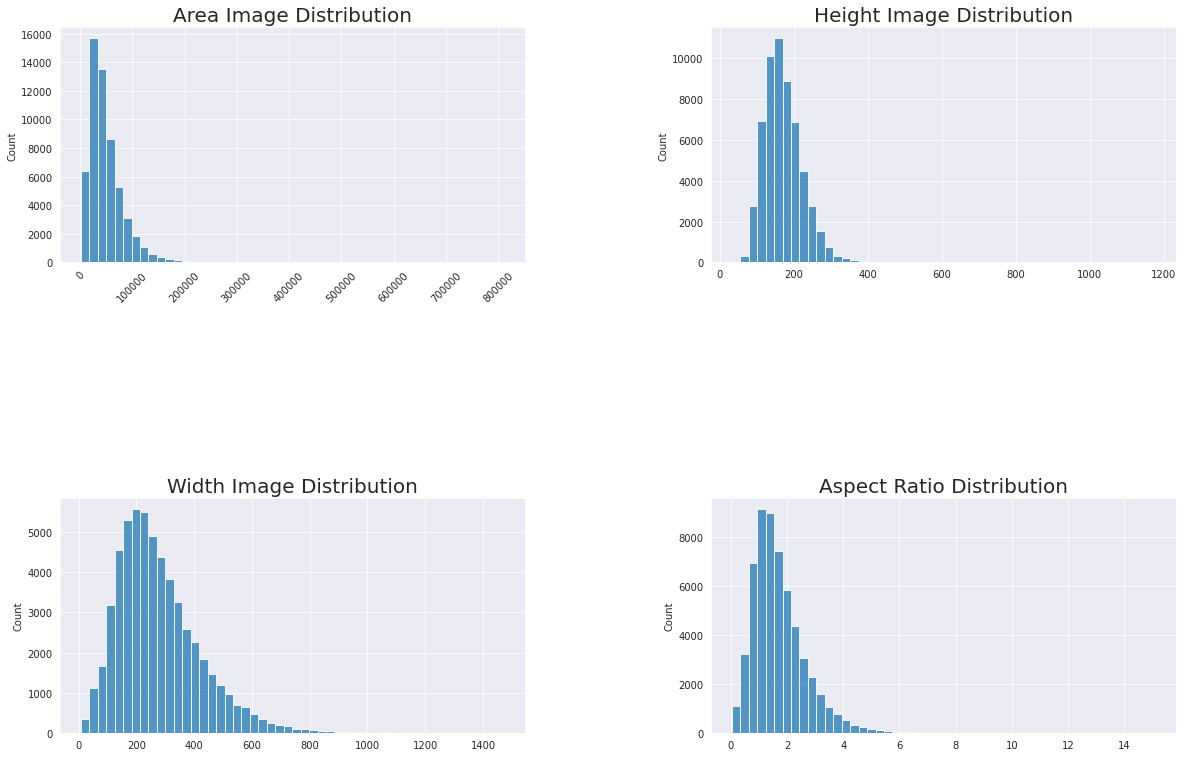

In [39]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(top = 0.5, bottom=0.01, hspace=1, wspace=0.4)

plt.subplot(2, 2, 1)
sns.histplot(np.array(h_shape) * np.array(w_shape), bins=50)
plt.xticks(rotation=45)
_ = plt.title("Area Image Distribution", fontsize=20)

plt.subplot(2, 2, 2)
sns.histplot(h_shape, bins=50)
_ = plt.title("Height Image Distribution", fontsize=20)

plt.subplot(2, 2, 3)
sns.histplot(w_shape, bins=50)
_ = plt.title("Width Image Distribution", fontsize=20)

plt.subplot(2, 2, 4)
sns.histplot(aspect_ratio, bins=50)
_ = plt.title("Aspect Ratio Distribution", fontsize=20)

**Setting padding image width & height are 600 & 300 respectively**

In [40]:
df = pd.DataFrame.from_dict({"Path": list(range(count)), "Labels": all_labels})
df["Path"] = df["Path"].apply(lambda x: f"images/{x}.png")

In [41]:
df.shape

(50773, 2)

In [42]:
df.sample(n=5)

,Path,Labels
1367,images/1367.png,WITHOUT
48867,images/48867.png,HALF.
37525,images/37525.png,USE
17981,images/17981.png,THE
40560,images/40560.png,PUPILS.


## Removing Further Error Cases

### Label is NaN

In [43]:
df = df.dropna(subset=["Labels"])

In [44]:
df.shape

(50773, 2)

### Mismatch - Type 1
***For cases where `len(gaps) > len(label)` are problematic cases***

Should it be modified to `len(gaps) > len(label)-1` as there's bound to be `n-1` gaps at max in a word of length `n`?

In [45]:
error_count, error_path, error_words = 0, [], []

for path, label in tqdm(zip(df["Path"].tolist(), df["Labels"].tolist())):
    try:
        image = cv2.imread(path, 0)
        image_invert = np.abs(image-255)
        vert_sum = np.sum(image_invert,axis=0)
        hori_sum = np.sum(image_invert,axis=1)
        image_reduced  = image[hori_sum>0,:][:,vert_sum>0]

        gaps = {}
        sanchk = True
        tmp_ind = 0
        for ind, i in enumerate(vert_sum):
            if i==0:
                if sanchk:
                    tmp_ind = ind
                    gaps[tmp_ind] = 0
                gaps[tmp_ind]+=1
                sanchk = False
            else:
                sanchk = True

        # cutting off whitespaces at the start & end (along x-axis)
        start_ind = 0
        end_ind = vert_sum.shape[0]-1
        if 0 in gaps:
            start_ind = gaps[0]
            del gaps[0]
        gaps_last = max(gaps.keys())
        if gaps_last+gaps[gaps_last]-1 == end_ind:
            end_ind = gaps_last
            del gaps[gaps_last]
        image = image[hori_sum>0,:][:,start_ind:end_ind]

        image_invert = np.abs(image-255)
        # re-calculating gap after removing whitespaces
        vert_sum = np.sum(image_invert,axis=0)
        gaps = {}
        sanchk = True
        tmp_ind = 0
        for ind, i in enumerate(vert_sum):
            if i==0:
                if sanchk:
                    tmp_ind = ind
                    gaps[tmp_ind] = 0
                gaps[tmp_ind]+=1
                sanchk = False
            else:
                sanchk = True
        
        if len(gaps) > len(label):
            error_count+=1
            error_path.append(path)
            error_words.append(label)
    except Exception as e:
        print(label)
        plt.figure()
        plt.imshow(image)

50773it [03:50, 220.54it/s]


In [46]:
print(f"# Errors: {error_count}")
len(error_path), len(error_words)

# Errors: 614


(614, 614)

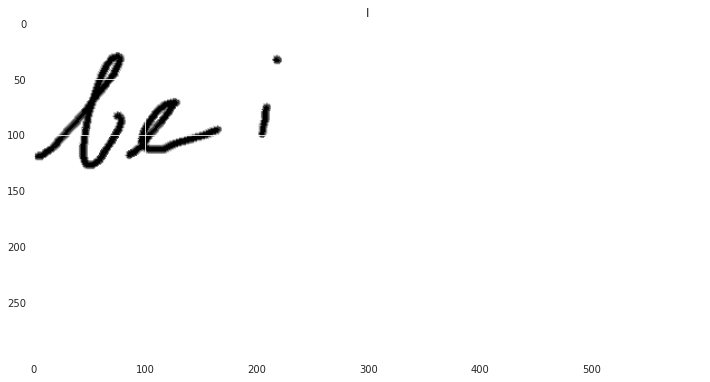

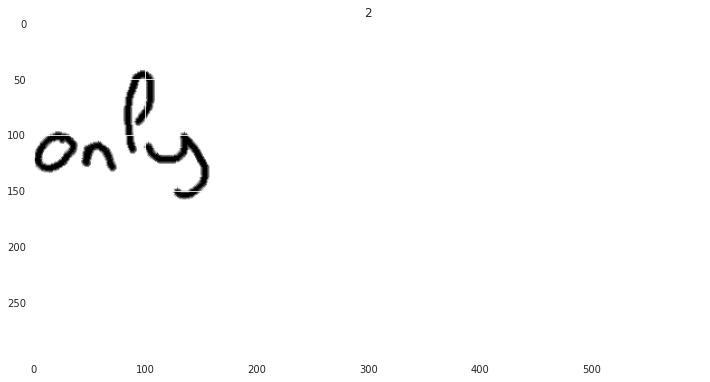

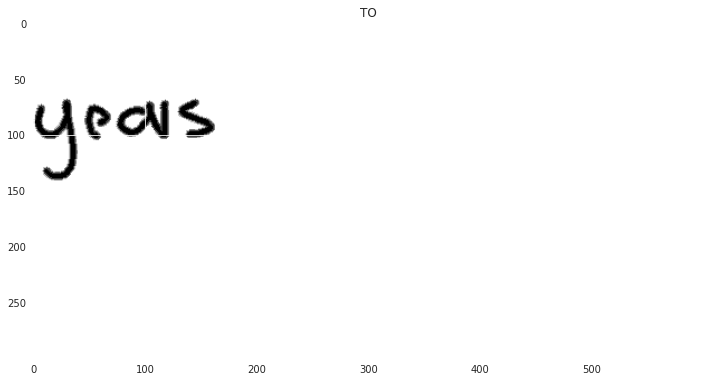

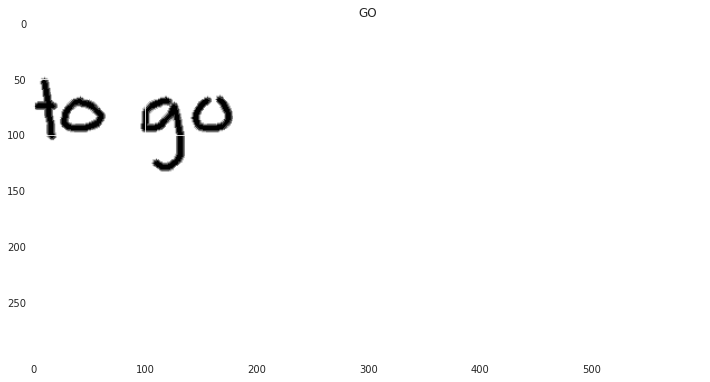

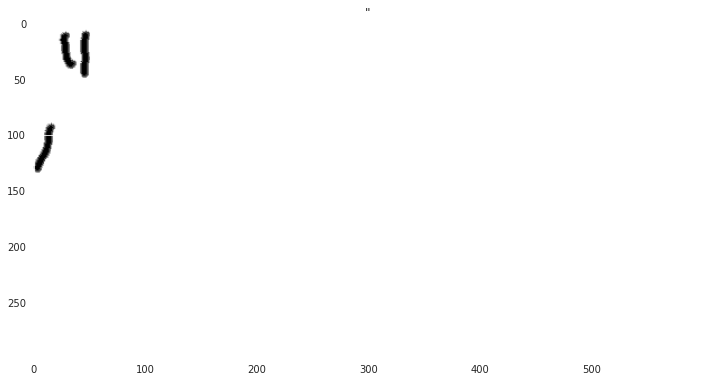

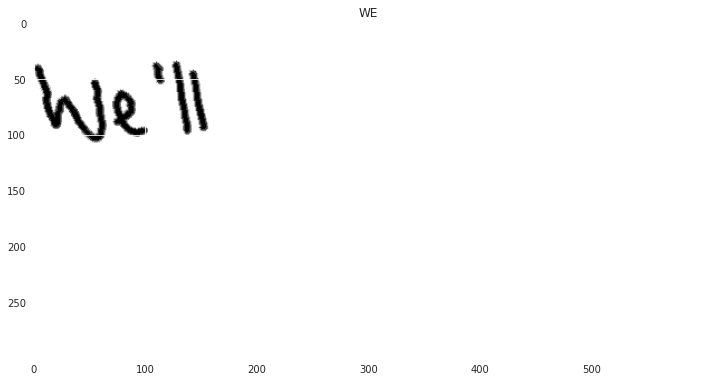

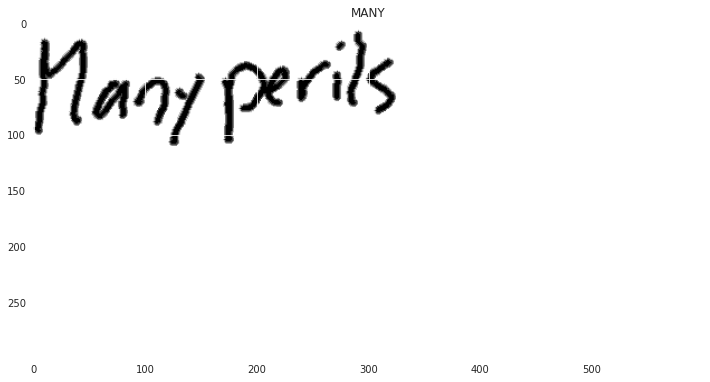

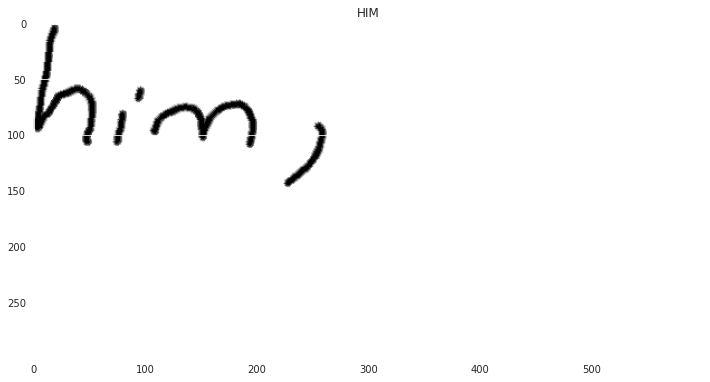

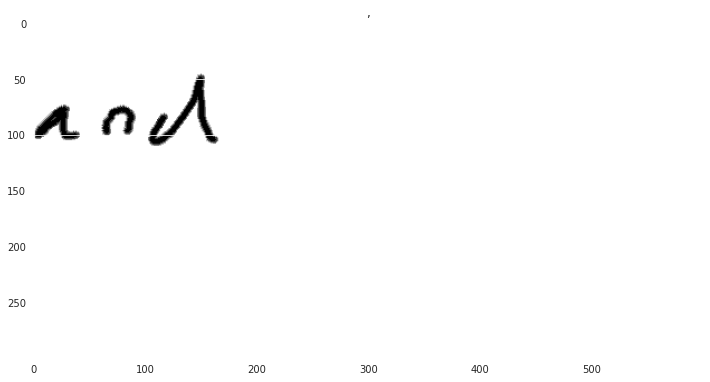

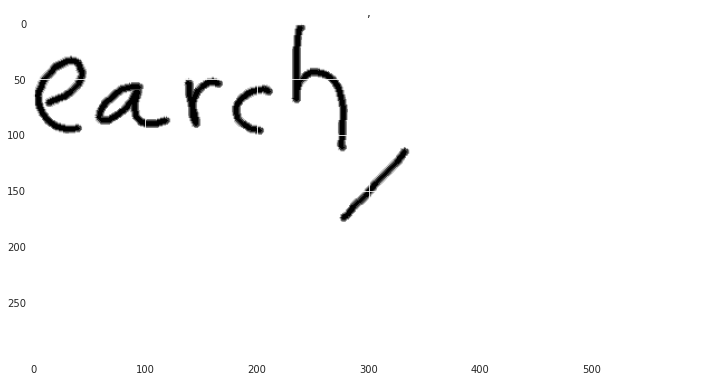

In [47]:
for path, label in zip(error_path[:10], error_words[:10]):
    img = cv2.imread(path)
    plt.figure()
    plt.imshow(img)
    plt.title(label)

***It's possible that the original image of which the above are sub-images too would be incorrect. Let's check***

In [48]:
x = int(error_path[2].split("/")[1].split(".")[0])
y = train_df.loc[train_df["Splits"].apply(lambda y: x in y)]["Splits"].tolist()[0]
print(x, y)

226 [220, 221, 222, 223, 224, 225, 226, 227, 228]


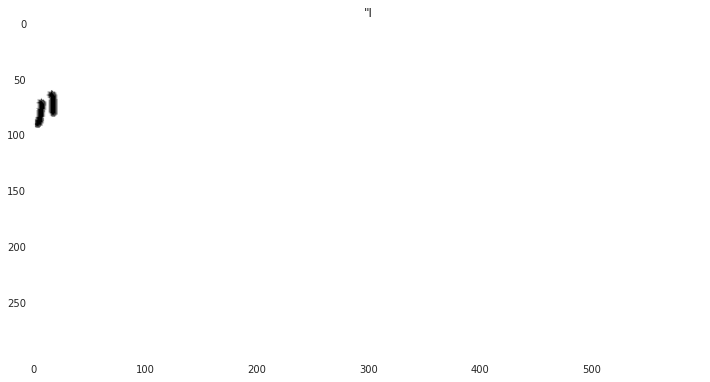

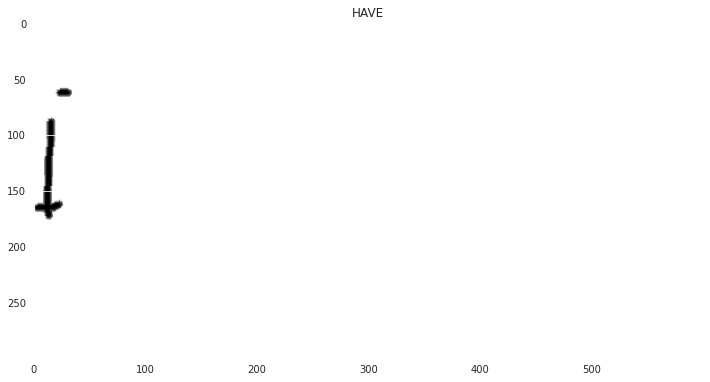

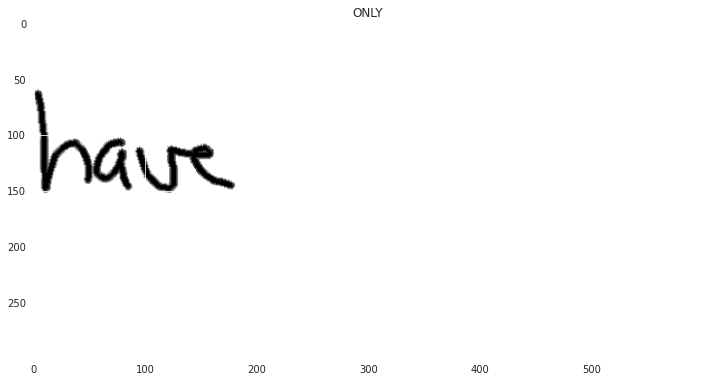

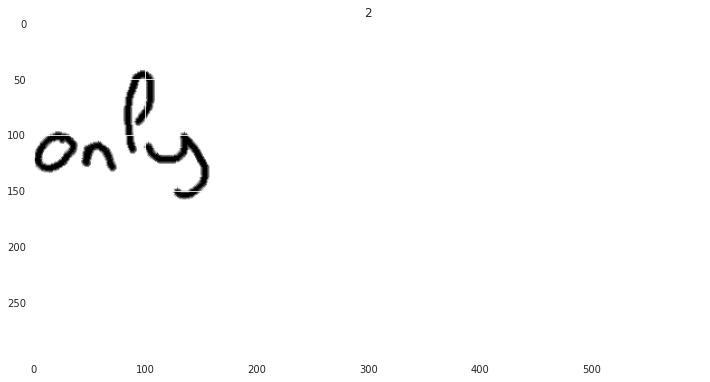

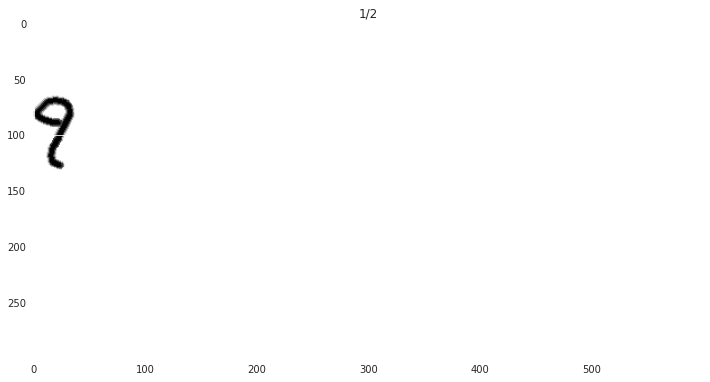

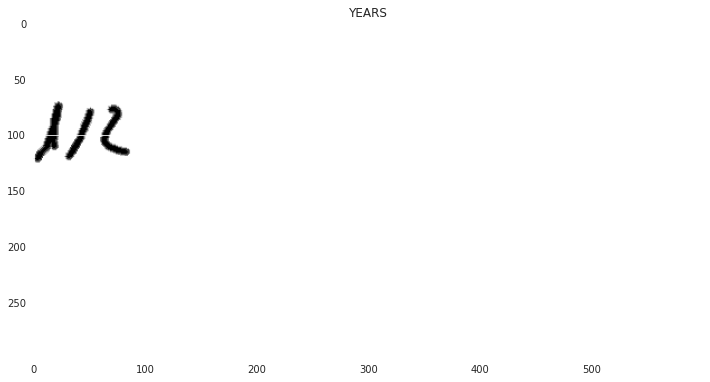

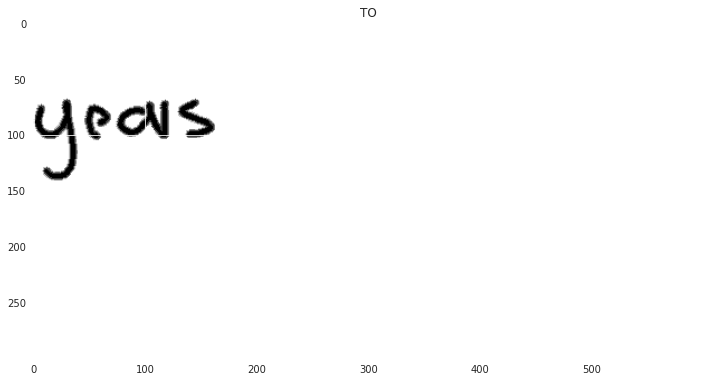

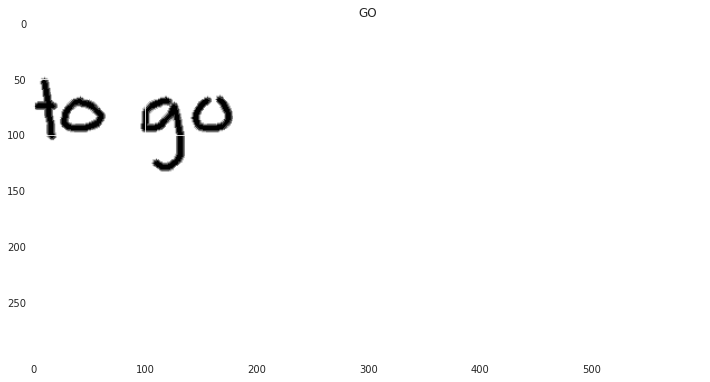

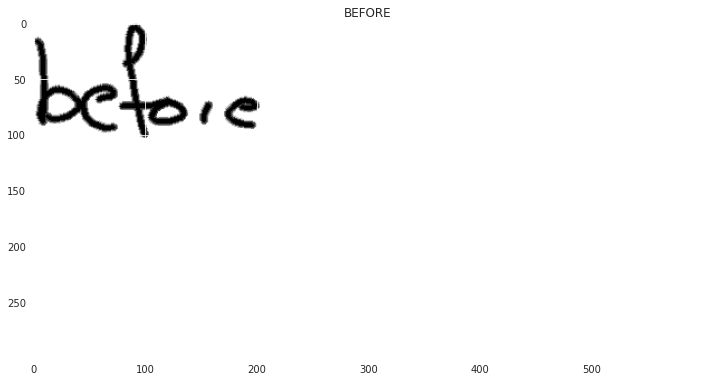

In [49]:
for idx, row in df.iloc[y].iterrows():
    img = cv2.imread(row["Path"])
    label = row["Labels"]
    plt.figure()
    plt.imshow(img)
    plt.title(label)

> Removing error cases & those of which they were a part

In [50]:
final_error_cases = []
for i in tqdm(range(len(error_path))):
    x = int(error_path[i].split("/")[1].split(".")[0])
    y = train_df.loc[train_df["Splits"].apply(lambda y: x in y)]["Splits"].tolist()[0]
    final_error_cases.extend(y)
print(f"# Total Error Cases: {len(final_error_cases)}")

100%|██████████| 614/614 [00:02<00:00, 213.02it/s]

# Total Error Cases: 3974


In [51]:
df = df.drop(index=final_error_cases)

In [52]:
df.shape

(47411, 2)

In [53]:
df.sample(5)

,Path,Labels
34462,images/34462.png,TAKE
23331,images/23331.png,ODOURS
17703,images/17703.png,ACCEPT
19703,images/19703.png,"PLEASANT-SPIRITED,"
20956,images/20956.png,THAT


### Mismatch - Type 2
***Cases where `len(splits) <  len(word)-1`. However, these are harder to detect, because of `cursive handwriting` which has joint characters***

But let's do it anyways & see if something comes up. **In the worst case, we might remove few from the training data manually**

The procedure is the same as above. Had created a separate notebook for it. Was able to find about 10 images but that was very boring - didn't had much success.

## Random Plots

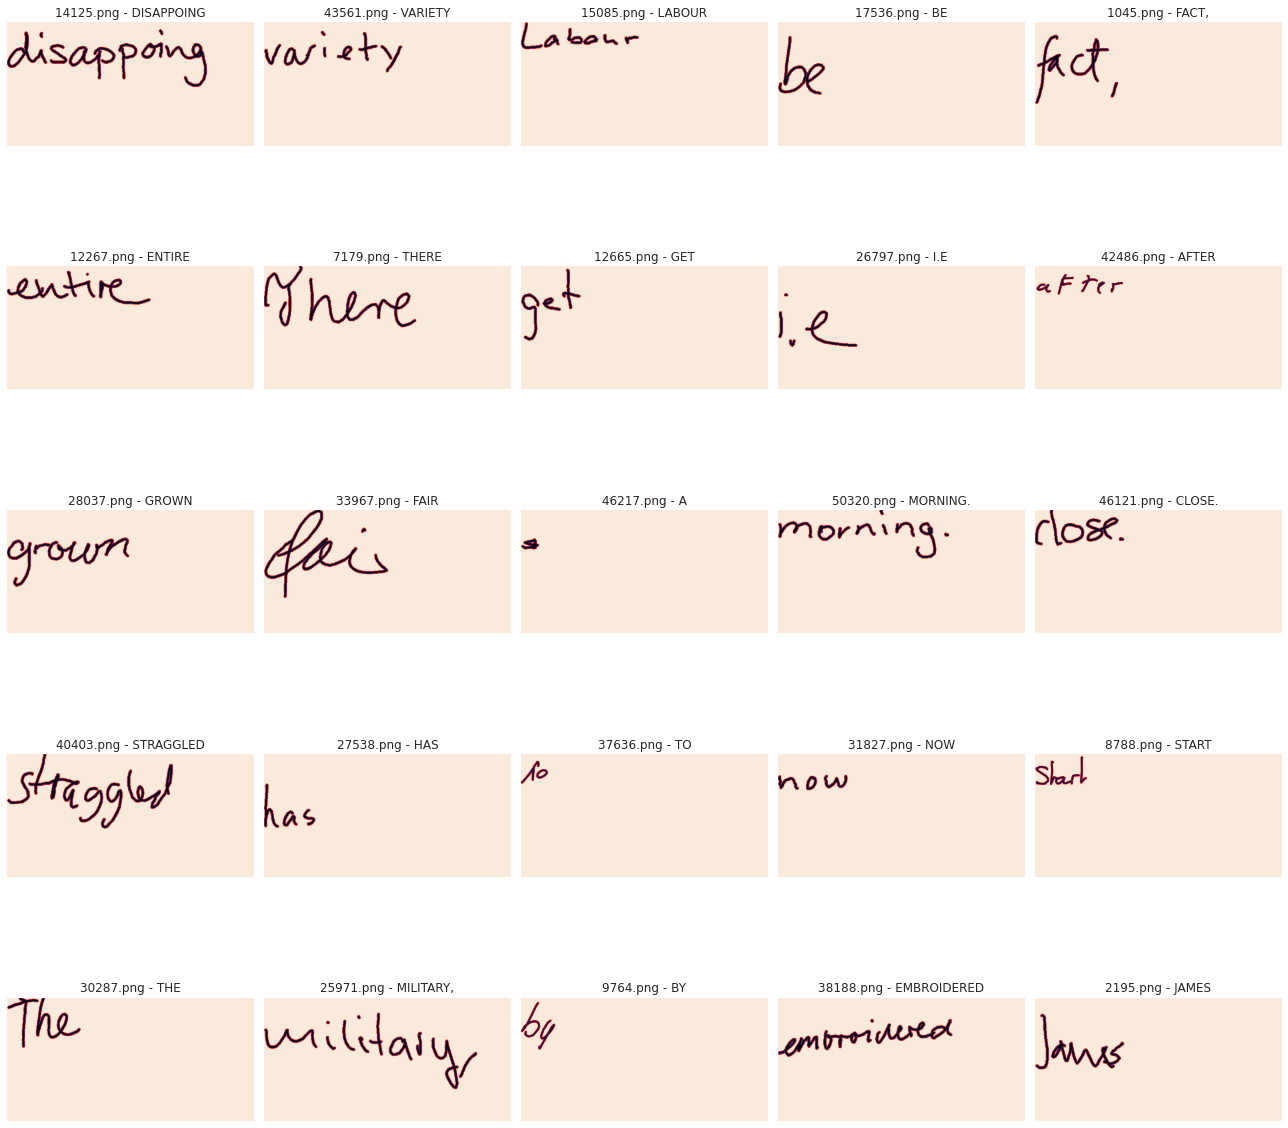

In [54]:
plot_grid(df["Path"].tolist(), df["Labels"].tolist(), h=5, w=5)

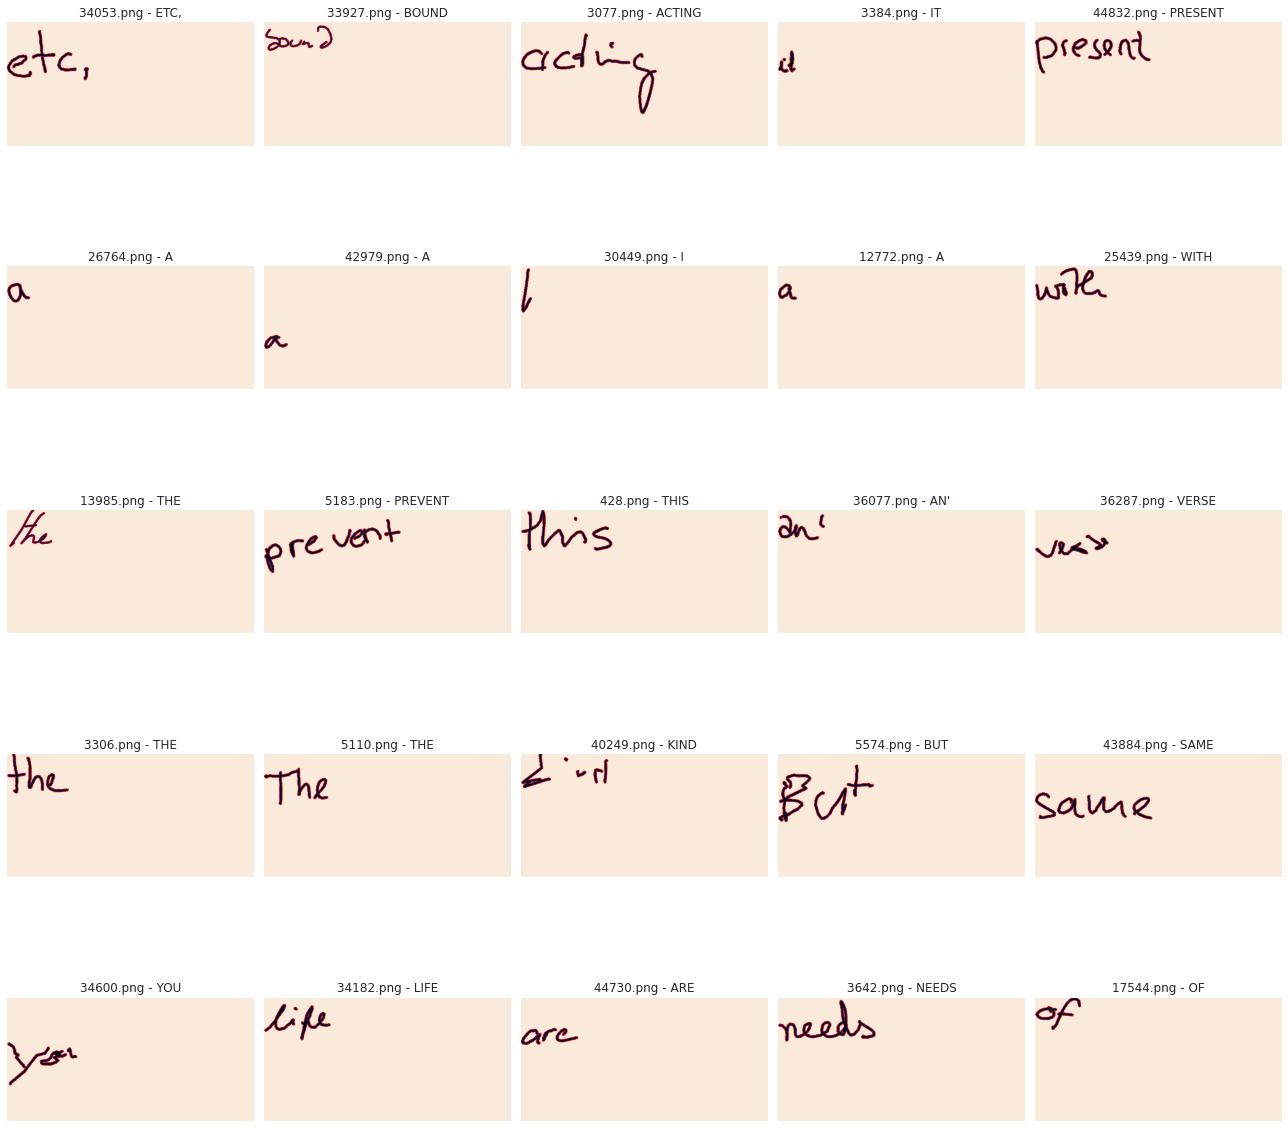

In [55]:
plot_grid(df["Path"].tolist(), df["Labels"].tolist(), h=5, w=5)

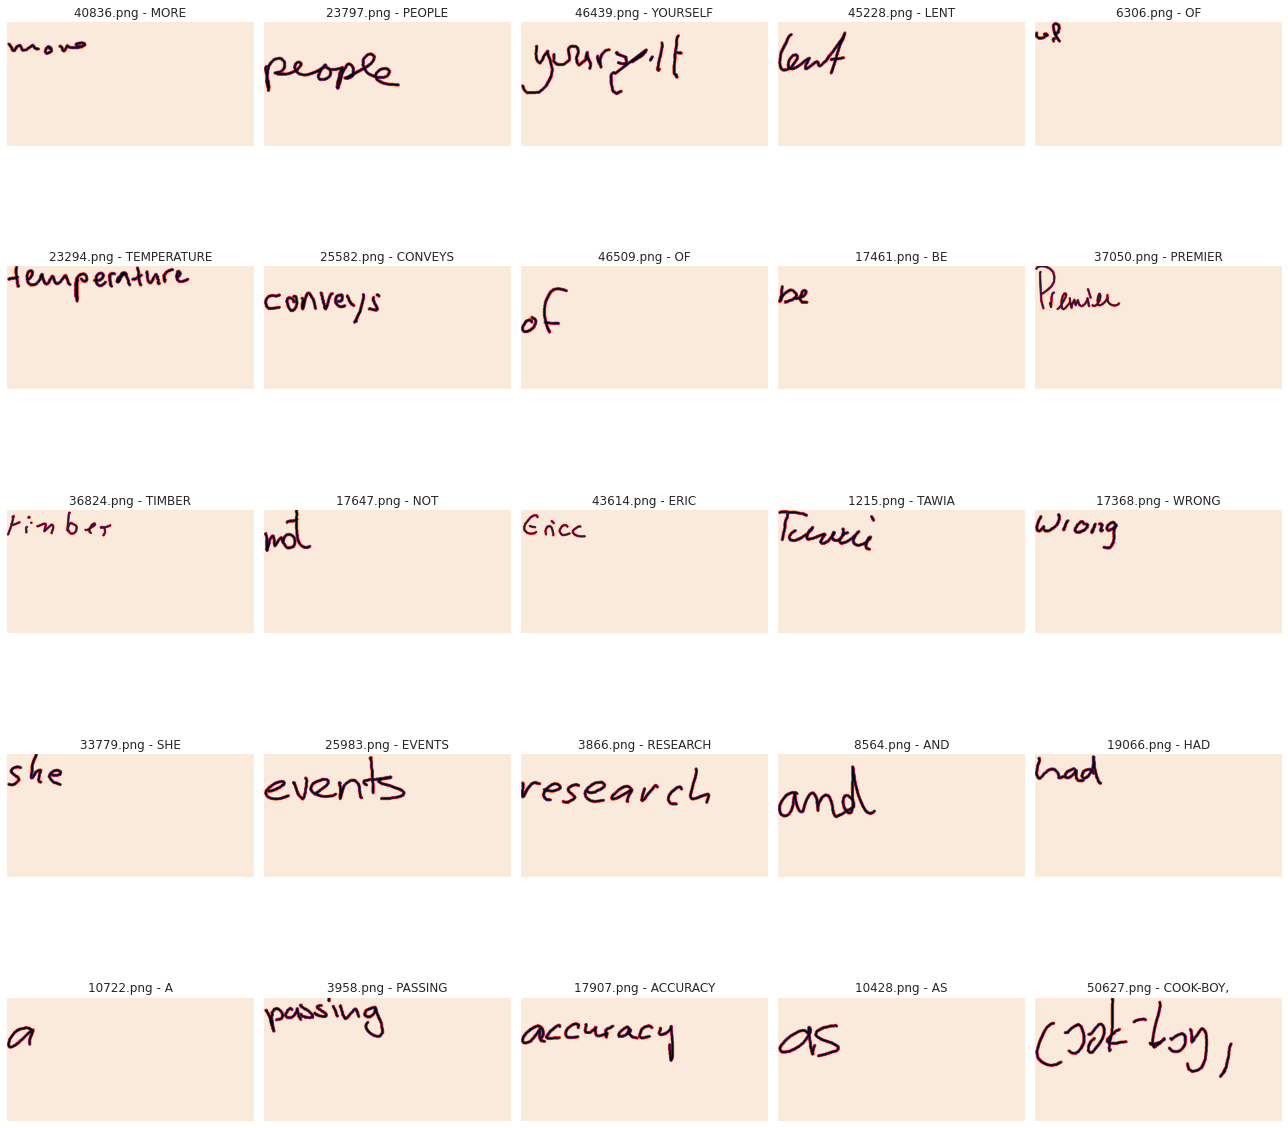

In [56]:
plot_grid(df["Path"].tolist(), df["Labels"].tolist(), h=5, w=5)

In [57]:
df.to_csv("train.csv")

In [58]:
!zip --quiet -r images.zip images
!rm -rf images/
!rm *.png